In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from musicautobot.imports import *
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.vocab import *

# Do this instead
from musicautobot.music_transformer.all import *
from musicautobot.multitask_transformer.all import *

In [4]:
from fastai.text.all import *

In [6]:
torch.cuda.set_device(2)

## MultitaskTransformer Training

Multitask Training is an extension of [MusicTransformer](../music_transformer/Train.ipynb).

Instead a basic language model that predicts the next word...

We train on multiple tasks
* [Next Word](../music_transformer/Train.ipynb)
* [Bert Mask](https://arxiv.org/abs/1810.04805)
* [Sequence to Sequence Translation](http://jalammar.github.io/illustrated-transformer/)

This gives a more generalized model and also let's you do some really cool [predictions](Generate.ipynb)

## End to end training pipeline 

1. Create and encode dataset
2. Initialize Transformer MOdel
3. Train
4. Predict

In [12]:
base_path = Path('../data/soundpack_midi')

# Location of your midi files
midi_path = base_path/'midi_sources/hooktheory'

# Location to save dataset
s2s_path = base_path/'s2s_encode/hooktheory'
lm_path = base_path/'piano_duet/hooktheory'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [14]:
midi_path.ls()

(#4) [Path('../data/soundpack_midi/midi_sources/hooktheory/billboard'),Path('../data/soundpack_midi/midi_sources/hooktheory/examples'),Path('../data/soundpack_midi/midi_sources/hooktheory/manual'),Path('../data/soundpack_midi/midi_sources/hooktheory/.DS_Store')]

In [20]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

2057

In [10]:
vocab = MusicVocab.create()
s2s_files = get_files(s2s_path, '.npy', recurse=True)[:400]
lm_files = get_files(lm_path, '.npy', recurse=True)[:400]

len(s2s_files), len(lm_files)

(0, 0)

### 2a. Create NextWord/Mask Dataset

In [7]:
tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
splits = RandomSplitter(seed=42)(range(len(lm_files)))
dsets = Datasets(lm_files, [tfms], splits=splits)

bs = 16
seq_len = 512

batch_tfms = [MaskLMTransform(vocab)]
dls = dsets.dataloaders(dl_type=LMDataLoader, 
                        bs=bs, seq_len=seq_len, cache=bs*4,
                        after_batch=batch_tfms,
                       ).cuda()

In [8]:
xb,yb = dls.one_batch()
xb['msk']['x'].shape

torch.Size([16, 512])

Key:
* 'msk' = masked input
* 'lm' = next word input
* 'pos' = timestepped postional encoding. This is in addition to relative positional encoding

Note: MultitaskTransformer trains on both the masked input ('msk') and next word input ('lm') at the same time.

The encoder is trained on the 'msk' data, while the decoder is trained on 'lm' data.



### 2b. Create sequence to sequence dataset

In [9]:
s2s_files = list(filter(is_valid_mtt, s2s_files))
len(s2s_files)

374

## S2S DataLoader

In [10]:
bs,seq_len = 2,8
tfms = [S2SFileTfm(vocab), partial(mtt2tensor, seq_len=seq_len)]
splits = RandomSplitter(seed=42)(range(len(s2s_files)))
dsets = Datasets(s2s_files, [tfms], splits=splits)

batch_tfms = [M2CTransform()]
dls = dsets.dataloaders(bs=bs, seq_len=seq_len,
                        after_batch=batch_tfms)


Structure

In [11]:
xb, yb = dls.one_batch(); xb

{'c2m': {'enc': tensor([[  5,   1,  75, 153,  68, 153,  65, 153],
          [  5,   1,  61, 149,  57, 149,  54, 149]], device='cuda:0'),
  'enc_pos': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
  'dec': tensor([[  6,   1,   8, 139,  75, 139,   8, 139],
          [  6,   1,  78, 140,   8, 140,  81, 140]], device='cuda:0'),
  'dec_pos': tensor([[0, 0, 0, 0, 2, 2, 2, 2],
          [0, 0, 0, 0, 0, 0, 3, 3]], device='cuda:0')},
 'm2c': {'enc': tensor([[  6,   1,   8, 139,  75, 139,   8, 139],
          [  6,   1,  78, 140,   8, 140,  81, 140]], device='cuda:0'),
  'enc_pos': tensor([[0, 0, 0, 0, 2, 2, 2, 2],
          [0, 0, 0, 0, 0, 0, 3, 3]], device='cuda:0'),
  'dec': tensor([[  5,   1,  75, 153,  68, 153,  65, 153],
          [  5,   1,  61, 149,  57, 149,  54, 149]], device='cuda:0'),
  'dec_pos': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}}

Key:
* 'c2m' = chord2melody translation
 * enc = chord
 * dec = melody
* 'm2c' = next word input
 * enc = melody
 * dec = chord
* 'pos' = timestepped postional encoding. Gives the model a better reference when translating

Note: MultitaskTransformer trains both translations ('m2c' and 'c2m') at the same time. 

## 2c. Stacked Dataloader

In [12]:
bs,seq_len = 2,8
s2s_tfms = [S2SFileTfm(vocab), partial(mtt2tensor, seq_len=seq_len)]
splits = RandomSplitter(seed=42)(range(len(s2s_files)))
s2s_dsets = Datasets(s2s_files, [s2s_tfms], splits=splits)

s2s_dls = s2s_dsets.dataloaders(
    bs=bs, seq_len=seq_len,
    after_batch=[M2CTransform()]
)


lm_tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
splits = RandomSplitter(seed=42)(range(len(lm_files)))
lm_dsets = Datasets(lm_files, [lm_tfms], splits=splits, dl_type=LMDataLoader)

lm_dls = lm_dsets.dataloaders(bs=bs, seq_len=seq_len, cache=bs*4,
                        after_batch=[MaskLMTransform(vocab)],
                       ).cuda()

In [14]:
class StackedDLs():
    def __init__(self, dls, num_it=100):
        self.dls = dls
        self.num_it = num_it
        self.dl_idx = -1
        
#     def __len__(self)->int: return sum([len(dl) for dl in self.dls])
    def __getattr__(self, attr):
        def redirected(*args, **kwargs):
            for dl in self.dls:
                if hasattr(dl, attr):
                    getattr(dl, attr)(*args, **kwargs)
        return redirected
        
    def __iter__(self):
        "Process and returns items from `DataLoader`."
        iters = [iter(dl) for dl in self.dls]
        self.dl_idx = -1
        while len(iters):
            self.dl_idx = (self.dl_idx+1) % len(iters)
            for b in range(self.num_it):
                try:
                    yield next(iters[self.dl_idx])
                except StopIteration as e:
                    iters.remove(iters[self.dl_idx])
                    break
#         raise StopIteration

#     def new(self, **kwargs):
#         "Create a new copy of `self` with `kwargs` replacing current values."
#         new_dls = [dl.new(**kwargs) for dl in self.dls]
#         return StackedDataloader(new_dls, self.num_it)


In [15]:
sdls = StackedDLs([s2s_dls, lm_dls])

In [16]:
len(sdls)

TypeError: object of type 'StackedDLs' has no len()

## 3. Initialize Model

In [10]:
# Load Data
batch_size = 2
bptt = 128

lm_data = load_data(data_path, data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm_pitchdur)

s2s_data = load_data(data_path, s2s_data_save_name, 
                     bs=batch_size//2, bptt=bptt,
                     preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

# Combine both dataloaders so we can train multiple tasks at the same time
data = StackedDataBunch([lm_data, s2s_data])

In [23]:
import musicautobot.utils.fastai_transformer as ft

# Create Model
config = ft.tfmer_lm_config.copy()

# Create Model
config = ft.tfmer_lm_config.copy()
config['mem_len'] = 512
learn = multitask_model_learner(dls, config.copy())
# learn.to_fp16(dynamic=True) # Enable for mixed precision

In [12]:
learn.model

MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=512, out_features=512, bias=True)
        )
        (mha2): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=

# 4. Train

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,7.605104,12.079700,0.000000,0.000000,0.251312,0.117202,00:13
1,7.555094,9.073783,0.000000,0.088274,0.251312,0.117202,00:13
2,7.236278,11.516213,0.039823,0.000000,0.251312,0.117202,00:13
3,7.062389,8.917387,0.266644,0.127444,0.251312,0.117202,00:13


In [14]:
learn.save('example')

PosixPath('../../data/numpy/models/example.pth')

## Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [20]:
# midi_files = get_files(midi_path, '.mid', recurse=True)
midi_file = base_path/'midi/notebook_examples/single_bar_example.mid'; midi_file

PosixPath('../../data/midi/notebook_examples/single_bar_example.mid')

/home/ashaw/musicautobot/musicautobot/multitask_transformer/learner.py:102: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_choices = len(probs.nonzero().view(-1))


Non midi note detected. Only returning valid portion. Index, seed 26 (28, 2)


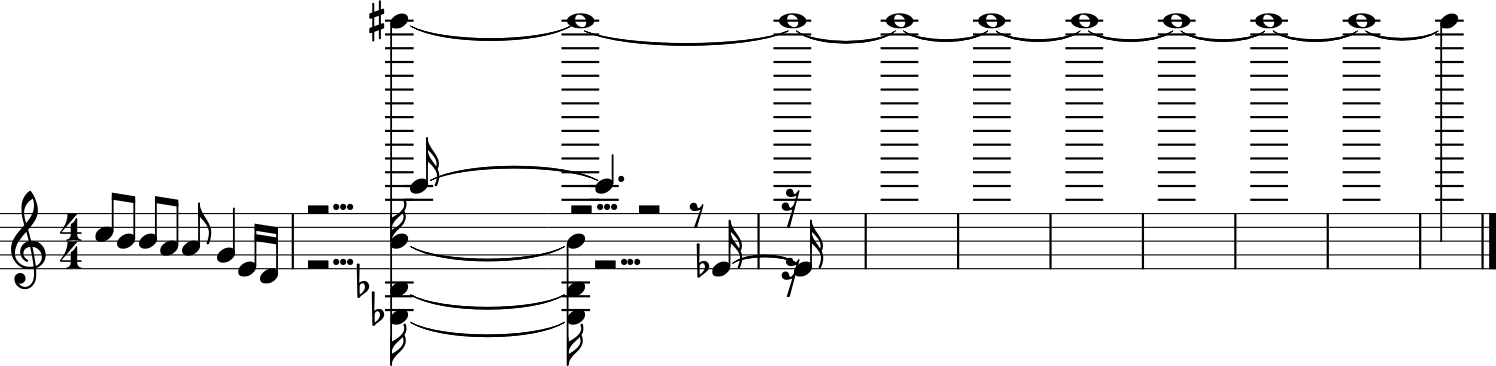

In [21]:
next_word = nw_predict_from_midi(learn, midi_file, n_words=20, seed_len=8); next_word.show()

Predicted past counter-part length. Returning early


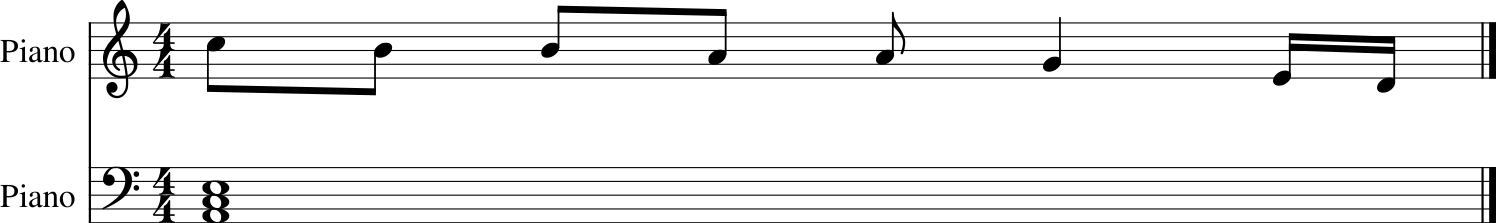

In [22]:
pred_melody = s2s_predict_from_midi(learn, midi_file, n_words=20, seed_len=4, pred_melody=True); pred_melody.show()

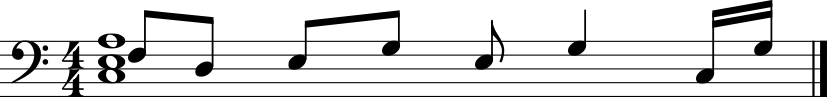

In [23]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()